In [1]:
import numpy as np
from model_vanilla_zoom import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt
import os

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
# file_name = 'zoom_aug_argminW_alphamax1.67_lr0.0002'
# out_dir_path = '/data/scratch/jahanian/mnist_dcgantf_bkup/out_old'
file_name = 'zoom_aug_argminW_alphamax1.67_lr0.0002'
out_dir_path = './out'
checkpoint_dir = os.path.join(out_dir_path,file_name,'checkpoint' )
sample_dir = os.path.join(out_dir_path,file_name,'sample' )
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_boolean("aug", False, "True for enabling transformation augmentation")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    aug=FLAGS.aug,    
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

zoom aug is disabled
loading mnist without augmenting ...
Building model_vanilla_zoom ...
 [*] Reading checkpoints... ./out/zoom_aug_argminW_alphamax1.67_lr0.0002/checkpoint
INFO:tensorflow:Restoring parameters from ./out/zoom_aug_argminW_alphamax1.67_lr0.0002/checkpoint/model.b64-81800
 [*] Success to read model.b64-81800


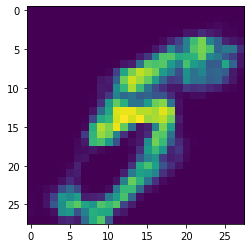

In [8]:
## Testing previously trained G
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(FLAGS.y_dim, num_samples)
y_one_hot = np.zeros((num_samples, FLAGS.y_dim))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [9]:
## steerability walk
## define the graph
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

## this will go to get_target and then to the loss
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)

z_new = z_placeholder-tf.log(alpha)*w
y_new = y_placeholder

## this is our transformed
transformed_output = dcgan.my_sampler(z_new, y_new)

loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

## the graph already contains DCGAN and now we want to init the steerability part in it:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [10]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    
    mask_fn = np.ones(outputs_zs.shape)
    
    if alpha == 1:
        return outputs_zs, mask_fn
    
    new_size = int(alpha*img_size)

    ## crop
    if alpha < 1:
        output_cropped = outputs_zs[:,img_size//2-new_size//2:img_size//2+new_size//2, img_size//2-new_size//2:img_size//2+new_size//2,:]
        mask_cropped = mask_fn
    ## padding
    else:
        output_cropped = np.zeros((outputs_zs.shape[0], new_size, new_size, outputs_zs.shape[3]))
        mask_cropped = np.zeros((outputs_zs.shape[0], new_size, new_size, outputs_zs.shape[3]))
        output_cropped[:, new_size//2-img_size//2:new_size//2+img_size//2, new_size//2-img_size//2:new_size//2+img_size//2,:] = outputs_zs 
        mask_cropped[:, new_size//2-img_size//2:new_size//2+img_size//2, new_size//2-img_size//2:new_size//2+img_size//2,:] = mask_fn
    
    ## Resize
    target_fn = np.zeros(outputs_zs.shape)
    mask_out = np.zeros(outputs_zs.shape)
    for i in range(outputs_zs.shape[0]):
        target_fn[i,:,:,:] = np.expand_dims(cv2.resize(output_cropped[i,:,:,:], (img_size, img_size), interpolation = cv2.INTER_LINEAR), axis=2)
        mask_out[i,:,:,:] = np.expand_dims(cv2.resize(mask_cropped[i,:,:,:], (img_size, img_size), interpolation = cv2.INTER_LINEAR), axis=2)
        
    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)
    
    if show_img:
        print('Target image:')
        imshow_unscaled(target_fn)
    if show_mask:
        print('Target mask:')
        imshow_unscaled(mask_out)

    return target_fn, mask_out

In [11]:
# ! mkdir -p shift_l2_git/images
# ! mkdir -p shift_l2_git/output
import os
output_dir = './out/argminW/zoom_NoAug_l2_lr{}'.format(lr)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'output'), exist_ok=True)
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [12]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(output_dir, 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []
loss_vals = []

# train
train_sample_size = 20000
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples = train_sample_size
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []
    Loss_sum_iter = 0  
    
    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = np.random.uniform(0.6, 1.) 
            else:
                alpha_val = np.random.uniform(1., 1.67) 

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)

            Loss_sum = Loss_sum + curr_loss
            Loss_sum_iter = Loss_sum_iter + curr_loss
            
            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))

            alpha_list.append(alpha_val)

            if (optim_iter % 2500 == 0) and (optim_iter > 0):
                saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)
            
            if (optim_iter % 100 == 0) and (optim_iter > 0):
                loss_vals.append(Loss_sum_iter/(100*batch_size))
                Loss_sum_iter = 0
                print('Loss:', loss_vals)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)

In [13]:
train(dcgan.saver)

2019-09-23 12:10:03,511 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.1957862377166748, 0, 0, 0.1257016956806183, 0.6472203579107133
2019-09-23 12:10:03,521 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007988929748535156, 0, 10, 0.0981050506234169, 1.3268087896318332
2019-09-23 12:10:03,530 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008169174194335938, 0, 20, 0.011934041045606136, 0.9815755022674948
2019-09-23 12:10:03,540 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00853586196899414, 0, 30, 0.16824229061603546, 0.6127145854473951
2019-09-23 12:10:03,549 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007911443710327148, 0, 40, 0.11588731408119202, 0.7252242541560228
2019-09-23 12:10:03,559 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008162975311279297, 0, 50, 0.13406682014465332, 1.4911149630515041
2019-09-23 12:10:03,568 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007919073104858398, 0, 60, 0.016015587374567986, 1.044392562618181
2019-09-23 12:10:03,577 [MainThread  ] 

2019-09-23 12:10:04,095 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008628368377685547, 0, 600, 0.06421114504337311, 0.7805792434199624
2019-09-23 12:10:04,105 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008571863174438477, 0, 610, 0.016587581485509872, 0.8725510782455248
2019-09-23 12:10:04,115 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009197473526000977, 0, 620, 0.07251486927270889, 0.7048058712112911
2019-09-23 12:10:04,126 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0091094970703125, 0, 630, 0.030206583440303802, 1.3044461411665558
2019-09-23 12:10:04,136 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009108781814575195, 0, 640, 0.00692404992878437, 0.9858461789885951
2019-09-23 12:10:04,147 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00936126708984375, 0, 650, 0.019943062216043472, 1.1099296525861753
2019-09-23 12:10:04,159 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010233640670776367, 0, 660, 0.020621517673134804, 0.9138662271899038
2019-09-23 12:10:04,169 [M

2019-09-23 12:10:04,677 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00813746452331543, 0, 1190, 0.06589727103710175, 0.6494968020849599
2019-09-23 12:10:04,687 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008591651916503906, 0, 1200, 0.02695392444729805, 0.8209370522163353
2019-09-23 12:10:04,696 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008184194564819336, 0, 1210, 0.10156933218240738, 0.6233572929166648
2019-09-23 12:10:04,706 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008524179458618164, 0, 1220, 0.07134497165679932, 1.57419737016607
2019-09-23 12:10:04,715 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008084297180175781, 0, 1230, 0.06530297547578812, 1.6439670463345952
2019-09-23 12:10:04,724 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008025646209716797, 0, 1240, 0.09727265685796738, 0.6597351612040582
2019-09-23 12:10:04,735 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008644819259643555, 0, 1250, 0.021488843485713005, 1.2223871405048814
2019-09-23 12:10:04,74

2019-09-23 12:10:05,238 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009200811386108398, 0, 1780, 0.07857969403266907, 0.6825605947284662
2019-09-23 12:10:05,248 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00960850715637207, 0, 1790, 0.05040006339550018, 0.7670089646136529
2019-09-23 12:10:05,259 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008907794952392578, 0, 1800, 0.015834001824259758, 0.863003781286829
2019-09-23 12:10:05,269 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00955820083618164, 0, 1810, 0.04076716676354408, 1.2959312969680306
2019-09-23 12:10:05,280 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009158134460449219, 0, 1820, 0.04609769210219383, 1.5373217599270532
2019-09-23 12:10:05,290 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008901119232177734, 0, 1830, 0.036812715232372284, 1.4848759173272734
2019-09-23 12:10:05,299 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00852203369140625, 0, 1840, 0.0006794043001718819, 1.0181279140914752
2019-09-23 12:10:05,

2019-09-23 12:10:05,841 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016539335250854492, 0, 2370, 0.016862474381923676, 1.16062100529957
2019-09-23 12:10:05,851 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008800268173217773, 0, 2380, 0.06912861764431, 0.7578807457782717
2019-09-23 12:10:05,861 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008359670639038086, 0, 2390, 0.02495870366692543, 0.8391025818442462
2019-09-23 12:10:05,872 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009141683578491211, 0, 2400, 0.04791228100657463, 0.726242052127309
2019-09-23 12:10:05,885 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011921405792236328, 0, 2410, 0.04859442263841629, 1.5049889813230697
2019-09-23 12:10:05,893 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007117033004760742, 0, 2420, 0.12745116651058197, 0.630782671093064
2019-09-23 12:10:05,902 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008118867874145508, 0, 2430, 0.08158254623413086, 0.6348548644030663
2019-09-23 12:10:05,912 [M

2019-09-23 12:10:06,429 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008183717727661133, 0, 2960, 0.02376641146838665, 1.300622902425551
2019-09-23 12:10:06,439 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00835561752319336, 0, 2970, 0.058110471814870834, 1.6279332821414385
2019-09-23 12:10:06,449 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009000301361083984, 0, 2980, 0.014135482721030712, 1.21838684135215
2019-09-23 12:10:06,462 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012126445770263672, 0, 2990, 0.05922110378742218, 1.623472387401799
2019-09-23 12:10:06,474 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009247064590454102, 0, 3000, 0.03876616433262825, 1.4902756859984794
Loss: [0.005527895484876353, 0.0039481337689212526, 0.0034440882381036315]
2019-09-23 12:10:06,484 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008490324020385742, 0, 3010, 0.08766548335552216, 0.6823107083641203
2019-09-23 12:10:06,493 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00860309600830078

2019-09-23 12:10:07,021 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008811712265014648, 0, 3550, 0.00020150214550085366, 1.0110567285457048
2019-09-23 12:10:07,031 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008532285690307617, 0, 3560, 0.04665443301200867, 1.331762254980815
2019-09-23 12:10:07,041 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008508920669555664, 0, 3570, 0.05538158491253853, 1.4392274630850426
2019-09-23 12:10:07,050 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008616447448730469, 0, 3580, 0.02651180326938629, 1.2621997278884716
2019-09-23 12:10:07,060 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008821725845336914, 0, 3590, 0.03248082846403122, 1.518592161030949
2019-09-23 12:10:07,070 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00881195068359375, 0, 3600, 0.03527383506298065, 1.4075108168474824
2019-09-23 12:10:07,080 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009094715118408203, 0, 3610, 0.03650142252445221, 0.7449700121582434
2019-09-23 12:10:07,

2019-09-23 12:10:07,599 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009091377258300781, 0, 4130, 0.018240461125969887, 1.2196663370742467
2019-09-23 12:10:07,609 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009109258651733398, 0, 4140, 0.03653443977236748, 1.50958987368152
2019-09-23 12:10:07,619 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00923299789428711, 0, 4150, 0.023557301610708237, 0.9267693137041914
2019-09-23 12:10:07,629 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00867462158203125, 0, 4160, 0.019747242331504822, 0.8697373174475573
2019-09-23 12:10:07,642 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01198434829711914, 0, 4170, 0.02961749956011772, 1.3353575594734355
2019-09-23 12:10:07,653 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008989572525024414, 0, 4180, 0.09788845479488373, 0.6413212387522038
2019-09-23 12:10:07,663 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008805036544799805, 0, 4190, 0.033549051731824875, 1.3462179584814777
2019-09-23 12:10:07,6

2019-09-23 12:10:08,202 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008943319320678711, 0, 4720, 0.03454601392149925, 1.2791075600160946
2019-09-23 12:10:08,211 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008317708969116211, 0, 4730, 0.06887472420930862, 0.7495060251505183
2019-09-23 12:10:08,222 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009622573852539062, 0, 4740, 0.04446101188659668, 0.7538428551147762
2019-09-23 12:10:08,232 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00841069221496582, 0, 4750, 0.04338036850094795, 1.6082168249793827
2019-09-23 12:10:08,243 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00867152214050293, 0, 4760, 0.03322714567184448, 1.3058729905928228
2019-09-23 12:10:08,253 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008758544921875, 0, 4770, 0.06429789960384369, 1.6189340601552482
2019-09-23 12:10:08,263 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00850224494934082, 0, 4780, 0.05822154879570007, 1.5729720063998287
2019-09-23 12:10:08,274 [M

2019-09-23 12:10:08,793 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008542537689208984, 0, 5300, 0.0021171823609620333, 1.0352541526873429
2019-09-23 12:10:08,803 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008594512939453125, 0, 5310, 0.04115128144621849, 0.7965791654267109
2019-09-23 12:10:08,813 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009193897247314453, 0, 5320, 0.006737968418747187, 1.099729477190416
2019-09-23 12:10:08,824 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008986234664916992, 0, 5330, 0.06476997584104538, 0.7725187349123739
2019-09-23 12:10:08,835 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010121583938598633, 0, 5340, 0.019875653088092804, 1.1306259671099168
2019-09-23 12:10:08,846 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009919404983520508, 0, 5350, 0.04345624893903732, 1.6011424843646798
2019-09-23 12:10:08,857 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00972747802734375, 0, 5360, 0.025498831644654274, 1.3022898694255645
2019-09-23 12:10:

2019-09-23 12:10:09,410 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009847402572631836, 0, 5890, 0.03862708806991577, 1.6511849298136427
2019-09-23 12:10:09,420 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009038209915161133, 0, 5900, 0.028192436322569847, 1.439909820549671
2019-09-23 12:10:09,431 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008999347686767578, 0, 5910, 0.017659040167927742, 1.155436207552026
2019-09-23 12:10:09,441 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00912618637084961, 0, 5920, 0.0164326261729002, 1.0466410649925306
2019-09-23 12:10:09,451 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008900880813598633, 0, 5930, 0.006273044738918543, 0.9376869643370829
2019-09-23 12:10:09,461 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008269309997558594, 0, 5940, 0.025066090747714043, 1.259786461329175
2019-09-23 12:10:09,471 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00903630256652832, 0, 5950, 0.016850821673870087, 1.1254791507155084
2019-09-23 12:10:09,4

2019-09-23 12:10:10,030 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008928775787353516, 0, 6470, 0.03545919805765152, 1.4332216275230771
2019-09-23 12:10:10,046 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014751195907592773, 0, 6480, 0.03395014628767967, 0.7947297858042965
2019-09-23 12:10:10,058 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010039806365966797, 0, 6490, 0.00021833220671396703, 1.009986570802101
2019-09-23 12:10:10,069 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009722232818603516, 0, 6500, 0.019901679828763008, 0.8767363013901726
2019-09-23 12:10:10,080 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010296821594238281, 0, 6510, 0.03146770969033241, 1.5694843625521
2019-09-23 12:10:10,092 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009635210037231445, 0, 6520, 0.0406465120613575, 1.599656567755265
2019-09-23 12:10:10,103 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009821176528930664, 0, 6530, 0.04463254287838936, 1.6271120236225443
2019-09-23 12:10:10,11

2019-09-23 12:10:10,646 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008596658706665039, 0, 7050, 0.019839225336909294, 0.9042901014647206
2019-09-23 12:10:10,656 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009103059768676758, 0, 7060, 0.047668274492025375, 1.4400602420542912
2019-09-23 12:10:10,666 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009149789810180664, 0, 7070, 0.03986814618110657, 1.6397496112952021
2019-09-23 12:10:10,677 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009345531463623047, 0, 7080, 0.02015829272568226, 0.8654320348059331
2019-09-23 12:10:10,686 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008789300918579102, 0, 7090, 0.024883052334189415, 1.3661225258117047
2019-09-23 12:10:10,697 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008945703506469727, 0, 7100, 0.023888329043984413, 1.3218611620435035
2019-09-23 12:10:10,706 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008605003356933594, 0, 7110, 0.0709780603647232, 0.7031876504337815
2019-09-23 12:10:

2019-09-23 12:10:11,230 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008536100387573242, 0, 7640, 0.011469767428934574, 1.1496917800406636
2019-09-23 12:10:11,240 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008452892303466797, 0, 7650, 0.03200869634747505, 0.8176436577182535
2019-09-23 12:10:11,249 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008295774459838867, 0, 7660, 0.01524429488927126, 1.045182133875549
2019-09-23 12:10:11,259 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008704900741577148, 0, 7670, 0.04878874495625496, 1.5983437680326316
2019-09-23 12:10:11,270 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009534597396850586, 0, 7680, 0.0055685401894152164, 1.0742806990110012
2019-09-23 12:10:11,280 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009377717971801758, 0, 7690, 0.03979036584496498, 0.8442204738231082
2019-09-23 12:10:11,290 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008352994918823242, 0, 7700, 0.06001050025224686, 1.6283518654256084
2019-09-23 12:10:1

2019-09-23 12:10:11,800 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00831151008605957, 0, 8220, 0.013946597464382648, 0.8706764093561998
2019-09-23 12:10:11,810 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008700370788574219, 0, 8230, 0.03396529331803322, 1.3020431451002523
2019-09-23 12:10:11,819 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008155107498168945, 0, 8240, 0.04884427413344383, 1.3276815964227655
2019-09-23 12:10:11,828 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008405685424804688, 0, 8250, 0.019907798618078232, 0.9233345894496787
2019-09-23 12:10:11,838 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008476734161376953, 0, 8260, 0.029744355008006096, 1.381567728196289
2019-09-23 12:10:11,847 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00806117057800293, 0, 8270, 0.016961291432380676, 0.8596843420013269
2019-09-23 12:10:11,856 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008037328720092773, 0, 8280, 0.045264896005392075, 1.6630926294736406
2019-09-23 12:10:1

2019-09-23 12:10:12,366 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008538484573364258, 0, 8810, 0.05522026866674423, 0.7458513329699528
2019-09-23 12:10:12,377 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009182929992675781, 0, 8820, 0.01938905566930771, 1.3008978044298902
2019-09-23 12:10:12,386 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00838613510131836, 0, 8830, 0.027442168444395065, 0.8174550860824141
2019-09-23 12:10:12,396 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008986473083496094, 0, 8840, 0.00675844494253397, 1.1515749566211813
2019-09-23 12:10:12,405 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008337736129760742, 0, 8850, 0.018168840557336807, 1.2316800740019747
2019-09-23 12:10:12,415 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008590936660766602, 0, 8860, 0.006327295675873756, 0.959442323645465
2019-09-23 12:10:12,425 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008913516998291016, 0, 8870, 0.03323470801115036, 1.3997870787229059
2019-09-23 12:10:12

2019-09-23 12:10:12,910 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008218526840209961, 0, 9390, 0.006787177640944719, 1.081485016776088
2019-09-23 12:10:12,921 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009158849716186523, 0, 9400, 0.015480782836675644, 0.8699743867952445
2019-09-23 12:10:12,930 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008090019226074219, 0, 9410, 0.03636752814054489, 1.2637268898024692
2019-09-23 12:10:12,939 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008204936981201172, 0, 9420, 0.020707815885543823, 1.2925714109611066
2019-09-23 12:10:12,949 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008661508560180664, 0, 9430, 0.07172619551420212, 0.6971613560490484
2019-09-23 12:10:12,959 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00826406478881836, 0, 9440, 0.01405161339789629, 1.111183370625506
2019-09-23 12:10:12,968 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007880449295043945, 0, 9450, 0.028621364384889603, 1.2910321110057725
2019-09-23 12:10:12

2019-09-23 12:10:13,420 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006766080856323242, 0, 9980, 0.023768164217472076, 0.9178056621467467
2019-09-23 12:10:13,429 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008208751678466797, 0, 9990, 0.01503129955381155, 1.1210947651218552
2019-09-23 12:10:13,437 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007214069366455078, 0, 10000, 0.009966235607862473, 1.1534027857656668
Loss: [0.005527895484876353, 0.0039481337689212526, 0.0034440882381036315, 0.003877366024913499, 0.0034982841913588345, 0.0037820072527974843, 0.0035615288596454776, 0.00340961951011559, 0.00327698133442027, 0.0031401370098246843]
2019-09-23 12:10:13,445 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006963014602661133, 0, 10010, 0.06865096092224121, 0.7042576040210738
2019-09-23 12:10:13,453 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007210493087768555, 0, 10020, 0.06278945505619049, 0.7243878751957261
2019-09-23 12:10:13,462 [MainThread  ] [INFO ]  T, epc, bst, lss

2019-09-23 12:10:13,940 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009545087814331055, 0, 10550, 0.01828055828809738, 1.142545148554237
2019-09-23 12:10:13,950 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007981538772583008, 0, 10560, 0.006311075761914253, 0.9602739769981945
2019-09-23 12:10:13,959 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00829172134399414, 0, 10570, 0.005634854547679424, 0.9764458001906086
2019-09-23 12:10:13,969 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008410453796386719, 0, 10580, 0.016422299668192863, 0.9125847798656714
2019-09-23 12:10:13,978 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007953643798828125, 0, 10590, 0.029517177492380142, 0.7978889537759879
2019-09-23 12:10:13,987 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008180856704711914, 0, 10600, 0.06738817691802979, 0.7118446769699545
2019-09-23 12:10:13,996 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008329153060913086, 0, 10610, 0.030662795528769493, 1.3417565889777259
2019-09-23

2019-09-23 12:10:14,486 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008211135864257812, 0, 11120, 0.06335423141717911, 1.639533620874251
2019-09-23 12:10:14,495 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008349418640136719, 0, 11130, 0.015962600708007812, 1.2404174397464107
2019-09-23 12:10:14,505 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008400917053222656, 0, 11140, 0.042735420167446136, 1.4842022466914495
2019-09-23 12:10:14,514 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008365154266357422, 0, 11150, 0.016233237460255623, 1.2370667132687552
2019-09-23 12:10:14,523 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008337974548339844, 0, 11160, 0.040405504405498505, 0.850165034291215
2019-09-23 12:10:14,533 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008301973342895508, 0, 11170, 0.05099089816212654, 0.755320057847251
2019-09-23 12:10:14,543 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008984565734863281, 0, 11180, 0.03712726756930351, 1.5348622985793225
2019-09-23 1

2019-09-23 12:10:15,048 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008597373962402344, 0, 11700, 0.03723839297890663, 0.8515129865528007
2019-09-23 12:10:15,058 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008763790130615234, 0, 11710, 0.06651335954666138, 1.5901898844087032
2019-09-23 12:10:15,067 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008625268936157227, 0, 11720, 0.04171865060925484, 0.728022805119088
2019-09-23 12:10:15,077 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00867009162902832, 0, 11730, 0.042040642350912094, 1.607413813069246
2019-09-23 12:10:15,087 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008533954620361328, 0, 11740, 0.019387563690543175, 1.286940804026792
2019-09-23 12:10:15,097 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008915424346923828, 0, 11750, 0.006790793500840664, 0.9561674697426542
2019-09-23 12:10:15,107 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008833169937133789, 0, 11760, 0.014516226015985012, 0.8966629570182516
2019-09-23 12

2019-09-23 12:10:15,658 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009133100509643555, 0, 12270, 0.027968406677246094, 0.8051958488750606
2019-09-23 12:10:15,668 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00897216796875, 0, 12280, 0.009159622713923454, 0.9873316324262
2019-09-23 12:10:15,678 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00864267349243164, 0, 12290, 0.0479963980615139, 1.5513577284155557
2019-09-23 12:10:15,688 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008900880813598633, 0, 12300, 0.0012869347119703889, 1.0295601728481687
2019-09-23 12:10:15,698 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009097576141357422, 0, 12310, 0.020029611885547638, 1.1141551367448654
2019-09-23 12:10:15,709 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009014368057250977, 0, 12320, 0.018529655411839485, 0.9156512134265
2019-09-23 12:10:15,719 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00884556770324707, 0, 12330, 0.018468210473656654, 1.2183236146683323
2019-09-23 12:10:15

2019-09-23 12:10:16,290 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009233474731445312, 0, 12860, 0.05434707924723625, 0.733329893276724
2019-09-23 12:10:16,298 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007707118988037109, 0, 12870, 0.05217454209923744, 0.7765901311063912
2019-09-23 12:10:16,308 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008743762969970703, 0, 12880, 0.03491235896945, 0.8556835304108448
2019-09-23 12:10:16,318 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008893251419067383, 0, 12890, 0.06692654639482498, 0.750702305286841
2019-09-23 12:10:16,329 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009617328643798828, 0, 12900, 0.018916074186563492, 0.9220143512736279
2019-09-23 12:10:16,340 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00951695442199707, 0, 12910, 0.01865386962890625, 0.9065824938072643
2019-09-23 12:10:16,351 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009301424026489258, 0, 12920, 0.01140090636909008, 1.1589944467898412
2019-09-23 12:10:1

2019-09-23 12:10:16,882 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0086669921875, 0, 13420, 0.036499764770269394, 1.3975226000849172
2019-09-23 12:10:16,892 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009006023406982422, 0, 13430, 0.03764858469367027, 0.7251112929018722
2019-09-23 12:10:16,905 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008872032165527344, 0, 13440, 0.03501726686954498, 0.8148343786082265
2019-09-23 12:10:16,916 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009391307830810547, 0, 13450, 0.04819666966795921, 0.6791212036343781
2019-09-23 12:10:16,927 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009552240371704102, 0, 13460, 0.03245053067803383, 1.4233116768144125
2019-09-23 12:10:16,937 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008751392364501953, 0, 13470, 0.012652751058340073, 1.0688768591914477
2019-09-23 12:10:16,947 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009272098541259766, 0, 13480, 0.02867760881781578, 1.6059110466162507
2019-09-23 12:10

Loss: [0.005527895484876353, 0.0039481337689212526, 0.0034440882381036315, 0.003877366024913499, 0.0034982841913588345, 0.0037820072527974843, 0.0035615288596454776, 0.00340961951011559, 0.00327698133442027, 0.0031401370098246843, 0.003221447922041989, 0.0034416849249973894, 0.0030207567241577636, 0.0033960505581926556]
2019-09-23 12:10:17,527 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011035680770874023, 0, 14010, 0.01532422099262476, 1.1101692351755434
2019-09-23 12:10:17,539 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009589910507202148, 0, 14020, 0.0627344474196434, 0.7188462657877146
2019-09-23 12:10:17,549 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009277105331420898, 0, 14030, 0.04537833109498024, 1.6491320059127779
2019-09-23 12:10:17,559 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008864879608154297, 0, 14040, 0.043827105313539505, 0.686543184534852
2019-09-23 12:10:17,570 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009762287139892578, 0, 14050, 0.017012132331

2019-09-23 12:10:18,150 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008932828903198242, 0, 14570, 0.01718439720571041, 1.1405636604449831
2019-09-23 12:10:18,159 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00830984115600586, 0, 14580, 0.010351368226110935, 0.9913797680104964
2019-09-23 12:10:18,169 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008726358413696289, 0, 14590, 0.006654785480350256, 0.9670965164120287
2019-09-23 12:10:18,179 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008778572082519531, 0, 14600, 0.03790814056992531, 0.8424641719533109
2019-09-23 12:10:18,189 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008447647094726562, 0, 14610, 0.020334936678409576, 0.8047628927245934
2019-09-23 12:10:18,198 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008331060409545898, 0, 14620, 0.03788921236991882, 1.495172908793223
2019-09-23 12:10:18,207 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008194446563720703, 0, 14630, 0.01655915379524231, 0.9259397159226271
2019-09-23 1

2019-09-23 12:10:18,728 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008616209030151367, 0, 15130, 0.02895880863070488, 0.7882620982316519
2019-09-23 12:10:18,738 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00879359245300293, 0, 15140, 0.0028233136981725693, 1.0340318672261126
2019-09-23 12:10:18,748 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008977174758911133, 0, 15150, 0.005360818468034267, 0.9318642896693087
2019-09-23 12:10:18,758 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008842945098876953, 0, 15160, 0.0038310254458338022, 1.086655817127034
2019-09-23 12:10:18,768 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008922815322875977, 0, 15170, 0.03955254331231117, 1.5187859321828667
2019-09-23 12:10:18,778 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009244680404663086, 0, 15180, 0.08990917354822159, 0.6114684959893075
2019-09-23 12:10:18,788 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008691549301147461, 0, 15190, 0.0078025758266448975, 0.9492421386408119
2019-09-

2019-09-23 12:10:19,327 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008487939834594727, 0, 15710, 0.013892303220927715, 1.1581923689416254
2019-09-23 12:10:19,339 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010581016540527344, 0, 15720, 0.006793795619159937, 0.9414569411931902
2019-09-23 12:10:19,349 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008623600006103516, 0, 15730, 0.041264623403549194, 1.5152133821375608
2019-09-23 12:10:19,360 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00964045524597168, 0, 15740, 0.04752963036298752, 1.5489231720312588
2019-09-23 12:10:19,371 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009592771530151367, 0, 15750, 0.0828576534986496, 0.6357574335441697
2019-09-23 12:10:19,382 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009598731994628906, 0, 15760, 0.04525197297334671, 1.6641089370143587
2019-09-23 12:10:19,393 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009764432907104492, 0, 15770, 0.012392557226121426, 0.8832808079333674
2019-09-23 

2019-09-23 12:10:19,909 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008572101593017578, 0, 16270, 0.01310521736741066, 1.065482625695313
2019-09-23 12:10:19,918 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008479833602905273, 0, 16280, 0.016228077933192253, 1.2499812607046803
2019-09-23 12:10:19,928 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008343219757080078, 0, 16290, 0.012407670728862286, 0.8730298247030992
2019-09-23 12:10:19,937 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00853109359741211, 0, 16300, 0.019158808514475822, 0.864454287129341
2019-09-23 12:10:19,947 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008436203002929688, 0, 16310, 0.03763992339372635, 0.8357745949270571
2019-09-23 12:10:19,958 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009360074996948242, 0, 16320, 0.032060641795396805, 1.3588895515367574
2019-09-23 12:10:19,967 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008846282958984375, 0, 16330, 0.023170605301856995, 0.8108042069588237
2019-09-23 

2019-09-23 12:10:20,487 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00827479362487793, 0, 16850, 0.024692926555871964, 1.2179894160767546
2019-09-23 12:10:20,498 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009443044662475586, 0, 16860, 0.012181070633232594, 1.1588740839461156
2019-09-23 12:10:20,507 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008076190948486328, 0, 16870, 0.02393439970910549, 1.3301212730944072
2019-09-23 12:10:20,517 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008394718170166016, 0, 16880, 0.010933639481663704, 1.1541416010678542
2019-09-23 12:10:20,527 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008551359176635742, 0, 16890, 0.02946734055876732, 0.8325142638179618
2019-09-23 12:10:20,537 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008979320526123047, 0, 16900, 0.05171404033899307, 0.6908318694763249
2019-09-23 12:10:20,547 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008991479873657227, 0, 16910, 0.041879743337631226, 1.501556858995468
2019-09-23 

2019-09-23 12:10:21,066 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008366107940673828, 0, 17410, 0.030966496095061302, 1.2282194942458244
2019-09-23 12:10:21,076 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008200407028198242, 0, 17420, 0.054266005754470825, 0.6785344499846404
2019-09-23 12:10:21,085 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00796365737915039, 0, 17430, 0.039381880313158035, 1.594723530093664
2019-09-23 12:10:21,095 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008095979690551758, 0, 17440, 0.03570930287241936, 1.3982276868449732
2019-09-23 12:10:21,104 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008452653884887695, 0, 17450, 0.013845618814229965, 1.0629202028377038
2019-09-23 12:10:21,115 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0089111328125, 0, 17460, 0.07131530344486237, 0.609385784471901
2019-09-23 12:10:21,124 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008263587951660156, 0, 17470, 0.04207678511738777, 1.4215581364946293
2019-09-23 12:10:

2019-09-23 12:10:21,645 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008208036422729492, 0, 18000, 0.03597470372915268, 1.4138105319232641
Loss: [0.005527895484876353, 0.0039481337689212526, 0.0034440882381036315, 0.003877366024913499, 0.0034982841913588345, 0.0037820072527974843, 0.0035615288596454776, 0.00340961951011559, 0.00327698133442027, 0.0031401370098246843, 0.003221447922041989, 0.0034416849249973894, 0.0030207567241577636, 0.0033960505581926556, 0.0031484977234213147, 0.0029157911927759415, 0.003230355537325522, 0.0033638844164797775]
2019-09-23 12:10:21,655 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009155511856079102, 0, 18010, 0.06624243408441544, 0.6513014979637749
2019-09-23 12:10:21,664 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0081634521484375, 0, 18020, 0.008821644820272923, 0.9828252475115328
2019-09-23 12:10:21,674 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008497476577758789, 0, 18030, 0.02023930475115776, 0.8669097452453615
2019-09-23 12:10:21,684 

2019-09-23 12:10:22,207 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007386922836303711, 0, 18560, 0.05671556666493416, 0.6765744592725782
2019-09-23 12:10:22,215 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006787538528442383, 0, 18570, 0.0272974893450737, 1.2690885902959868
2019-09-23 12:10:22,223 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0071620941162109375, 0, 18580, 0.006649821996688843, 0.9724586534080932
2019-09-23 12:10:22,230 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006636857986450195, 0, 18590, 0.041435014456510544, 1.3264243827546283
2019-09-23 12:10:22,240 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008241653442382812, 0, 18600, 0.005824888125061989, 1.083223886805327
2019-09-23 12:10:22,248 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007729768753051758, 0, 18610, 0.013625884428620338, 0.8777040924754804
2019-09-23 12:10:22,257 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007873296737670898, 0, 18620, 0.04730023816227913, 1.5206605724987843
2019-09-23

2019-09-23 12:10:22,739 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008603811264038086, 0, 19110, 0.07996553927659988, 0.6170099769511784
2019-09-23 12:10:22,748 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008212089538574219, 0, 19120, 0.005631335079669952, 0.9415096564261036
2019-09-23 12:10:22,758 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008078575134277344, 0, 19130, 0.01849757321178913, 1.2357457974326458
2019-09-23 12:10:22,767 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008551359176635742, 0, 19140, 0.009897677227854729, 0.9971215637791058
2019-09-23 12:10:22,776 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00798344612121582, 0, 19150, 0.016367075964808464, 0.911594716742159
2019-09-23 12:10:22,785 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007836103439331055, 0, 19160, 0.08301208913326263, 0.604731311111798
2019-09-23 12:10:22,795 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008229732513427734, 0, 19170, 0.02357313223183155, 1.3774197259692045
2019-09-23 12

2019-09-23 12:10:23,348 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009246826171875, 0, 19700, 0.016329489648342133, 0.8705385335444249
2019-09-23 12:10:23,359 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009480953216552734, 0, 19710, 0.032250821590423584, 1.487814502744948
2019-09-23 12:10:23,369 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008934259414672852, 0, 19720, 0.04489051178097725, 1.4451644833588357
2019-09-23 12:10:23,379 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008770227432250977, 0, 19730, 0.09953661262989044, 0.6083004666391055
2019-09-23 12:10:23,389 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0092010498046875, 0, 19740, 0.03160477429628372, 1.4122916346058443
2019-09-23 12:10:23,400 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008979082107543945, 0, 19750, 0.04784785583615303, 0.6070553042334352
2019-09-23 12:10:23,409 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008390188217163086, 0, 19760, 0.09697497636079788, 0.6017239392515533
2019-09-23 12:10:

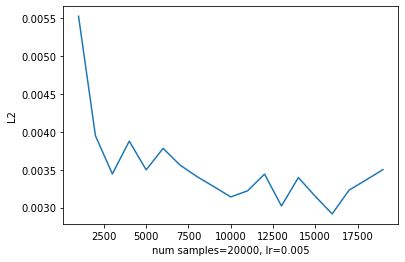

[0.005527895484876353, 0.0039481337689212526, 0.0034440882381036315, 0.003877366024913499, 0.0034982841913588345, 0.0037820072527974843, 0.0035615288596454776, 0.00340961951011559, 0.00327698133442027, 0.0031401370098246843, 0.003221447922041989, 0.0034416849249973894, 0.0030207567241577636, 0.0033960505581926556, 0.0031484977234213147, 0.0029157911927759415, 0.003230355537325522, 0.0033638844164797775, 0.0035007812643016224]


In [14]:
import matplotlib.pyplot as plt
loss_vals_x = np.arange(FLAGS.batch_size*100, train_sample_size, FLAGS.batch_size*100)
plt.plot(loss_vals_x, loss_vals)
plt.xlabel('num samples={}, lr={}'.format(train_sample_size, lr))
plt.ylabel('L2')
plt.show()
print(loss_vals)

In [15]:
# test: show imgs 
# Need work:
# saver.restore(sess, "./out/argminW/zoom_NoAug_l2_lr0.005/output/model_20000.ckpt")

[0.5        0.55555556 0.625      0.71428571 0.83333333 1.
 1.2        1.4        1.6        1.8        2.        ]


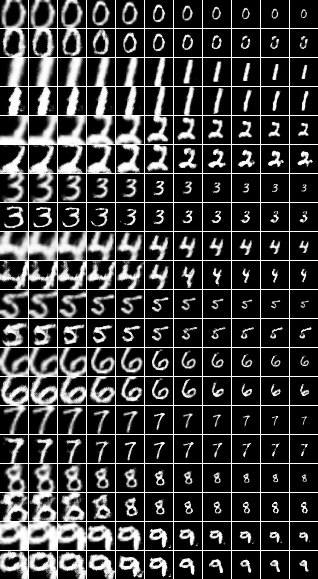

In [16]:
num_samples = 10

a = np.array([1.2, 1.4, 1.6, 1.8, 2.])
np.reciprocal(a[::-1])
b=[np.reciprocal(a[::-1]),np.array([1]),a]
a = np.concatenate(b)

zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

im_targets = []
im_transformed = []
for i in range(a.shape[0]):
    feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
    out_zs = sess.run(outputs_orig, feed_dict_out)
    target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
    im_targets.append(target_fn)
    ## get transformed:
    feed_dict = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}
    samples = sess.run(transformed_output, feed_dict=feed_dict)
    im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

ims = []
for j in range(FLAGS.y_dim):
    ims.append(np.stack([x[j, :, :, :] for x in im_targets], axis=0))
    ims.append(np.stack([x[j, :, :, :] for x in im_transformed], axis=0))

print(a)
imshow(imgrid(np.uint8(np.concatenate(ims)*255), cols=a.shape[0]))

In [17]:
loss_l2_sample = tf.reduce_sum(tf.multiply(tf.square(transformed_output-target), mask), axis=(1,2,3)) \
        / tf.reduce_sum(mask, axis=(1,2,3))

loss_l2_trained = loss

In [18]:
import logging
import sys
# import argparse
# from utils import *
# import graphs
# import constants
import time
import pdb
import os
# import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

num_samples = 10000
vocab_size = FLAGS.y_dim
batch_size = FLAGS.batch_size

z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
y_one_hot = np.zeros((len(y), FLAGS.y_dim))
y_one_hot[np.arange(len(y)), y] = 1
y_one_hot = np.tile(y_one_hot,[num_samples,1])

zs = z_sample
ys = y_one_hot
alphas = a 
alphas_no_log = a

# get alphas list
# if type(g) == graphs.ZoomTransform:
#     alp = np.linspace(1, opt.max_alpha, opt.num_alphas//2 + 1)
#     b = 1/alp
#     alphas = np.concatenate((np.delete(b[::-1], -1), alp), axis=0)
#     alphas = alphas[::-1]
# else:
#     alphas = np.linspace(-opt.max_alpha, opt.max_alpha, opt.num_alphas)
ylabel = 'L2 Error'
dist_tensor = loss_l2_sample
dist_trained_tensor = loss_l2_trained

# dist_info = compute_transform_similarity(...)
# plot_similarity(dist_info...)

# # if opt.distance == 'l2':
# #     ylabel = 'L2 Distance'
# #     dist_tensor = g.loss_l2_sample
# # elif opt.distance == 'lpips':
# #     ylabel = 'Perceptual Distance'
# #     dist_tensor = g.loss_lpips_sample
# dist_info = compute_transform_similarity(ys, zs, alphas, dist_tensor)
# plot_similarity(alphas, dist_info, ylabel, output_dir, 'category_all')
# # if opt.category:
# #     for c in opt.category:
# #         ys = [c] * num_samples
# #         ys = one_hot_if_needed(ys, vocab_size)
# #         dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                                  dist_tensor)
# #         plot_similarity(alphas, dist_info, ylabel,
# #                         output_dir, 'category_{}'.format(c))
# # else:
# #     categories = np.random.randint(0, vocab_size, size=num_samples)
# #     ys = one_hot_if_needed(categories, vocab_size)
# #     dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                              dist_tensor)
# #     plot_similarity(alphas, dist_info, ylabel, output_dir,
# #                     'category_all')

In [19]:
def scale_test_alpha_for_graph(alpha, zs_batch):
#     alpha = np.log(alpha) # only for zoom
    batch_size = zs_batch.shape[0]
    slider = alpha * np.ones((batch_size, Nsliders))
    return slider

In [20]:
alphas = alphas_no_log
dist_info = np.empty((num_samples, len(alphas) - 1))
dist_trained_info = np.empty((num_samples, len(alphas)))

for batch_start in range(0, num_samples, batch_size):
    s = slice(batch_start, min(num_samples, batch_start + batch_size))
    ys_batch = ys[s]
    zs_batch = zs[s]
    im_buffer = None # save the first set of images, for consecutive diff
    for i, a in enumerate(alphas):
        slider = scale_test_alpha_for_graph(a, zs_batch)
        input_test = {y_placeholder: ys_batch,
                      z_placeholder: zs_batch,
                      alpha: slider}
        im_transform = sess.run(transformed_output, feed_dict=input_test)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
        if im_buffer is not None:
            feed_dict = {
                mask: np.ones_like(im_transform),
                transformed_output: im_transform,
                target: im_buffer
            }
            # compute consecutive lpips diffs
            dist_info[s, i-1] = sess.run(dist_tensor, feed_dict=feed_dict)
#             print('consecutive diffs:', sess.run(dist_tensor, feed_dict=feed_dict))
        im_buffer = im_transform
    
        ## now compute the loss of train:
        ## already have im_transform, so get target and mask from G(a=0,z)
        out_zs = sess.run(outputs_orig, input_test)
        target_out, mask_out = get_target_np(out_zs, a)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
#         imshow(imgrid(np.uint8(target_out*255), cols=1))
#         imshow(imgrid(np.uint8(mask_out*255), cols=1))
        feed_dict = {
            mask: mask_out,
            transformed_output: im_transform,
            target: target_out
        }
        dist_trained_info[s, i] = sess.run(dist_trained_tensor, feed_dict=feed_dict)

alpha: -0.64, dist 0.02 +/- 0.01
alpha: -0.53, dist 0.02 +/- 0.02
alpha: -0.40, dist 0.03 +/- 0.02
alpha: -0.26, dist 0.04 +/- 0.03
alpha: -0.09, dist 0.04 +/- 0.03
alpha: 0.09, dist 0.03 +/- 0.03
alpha: 0.26, dist 0.02 +/- 0.02
alpha: 0.40, dist 0.01 +/- 0.01
alpha: 0.53, dist 0.01 +/- 0.01
alpha: 0.64, dist 0.00 +/- 0.01
2019-09-23 12:12:17,850 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-09-23 12:12:17,852 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.


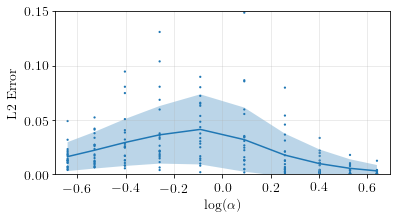

In [21]:
## plots and saves the computed similarity matrix
output_dir = './out/plots/zoom'
savefile_transform_effect = file_name+'_transform_effect_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
mu = np.mean(dist_info, axis=0)
sd = np.std(dist_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.15])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile_transform_effect + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile_transform_effect + '.pdf'),
          bbox_inches="tight", pad_inches=0)

In [22]:
dist_trained_joint = np.load(os.path.join(output_dir, 'zoom_aug_argminGW_alphamax1.67_lr0.0002_loss_trained_plots.npy'))
dist_trained_NoAug_argminGW = np.load(os.path.join(output_dir, 'zoom_NoAug_argminGW_alphamax1.67_lr0.0002_loss_trained_plots.npy'))
dist_trained_NoAug_argminW = np.load(os.path.join(output_dir, 'zoom_NoAug_argminW_lr0.0002_loss_trained_plots.npy'))


In [23]:
# ## plots and saves the computed similarity matrix
# output_dir = './out/plots/plots_zoom'
# savefile_loss = file_name+'_loss_trained_plots''

# alphas = alphas_no_log

# xlabel = r'$\alpha$'
# if np.min(alphas) > 0:
#     alphas = np.log(alphas)
#     xlabel = r'$\log(\alpha)$'
    
# f, ax = plt.subplots(figsize=(6, 3))
# # xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
# xaxis = np.mean([alphas[:], alphas[:]], axis=0)
# mu = np.mean(dist_trained_info, axis=0)
# sd = np.std(dist_trained_info, axis=0)
# p = ax.plot(xaxis, mu)
# ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
# xscatter = np.tile(xaxis, (20, 1))
# yscatter = dist_trained_info[:20] # take the first 20 samples
# ax.scatter(xscatter, yscatter, marker='.',
#            edgecolors='none', s=20, color=p[0].get_color())
# ax.set_xlabel(xlabel)
# ax.set_ylabel(ylabel)

# # ax.set_ylim([0, 0.8])
# ax.set_ylim([0, 0.3])
# ax.grid(alpha=0.3)
# # ax.set_xlim([np.min(alphas), np.max(alphas)])
# ax.set_xlim([np.min(alphas), np.max(alphas)])

# for (x, m, s) in zip(xaxis, mu, sd):
#     print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

# f.savefig(os.path.join(output_dir, savefile + '.png'),
#           bbox_inches="tight", pad_inches=0)
# f.savefig(os.path.join(output_dir, savefile + '.pdf'),
#           bbox_inches="tight", pad_inches=0)

alpha: -0.69, dist 0.11 +/- 0.02
alpha: -0.59, dist 0.12 +/- 0.02
alpha: -0.47, dist 0.09 +/- 0.01
alpha: -0.34, dist 0.05 +/- 0.01
alpha: -0.18, dist 0.03 +/- 0.01
alpha: 0.00, dist 0.00 +/- 0.00
alpha: 0.18, dist 0.02 +/- 0.00
alpha: 0.34, dist 0.04 +/- 0.01
alpha: 0.47, dist 0.05 +/- 0.01
alpha: 0.59, dist 0.06 +/- 0.01
alpha: 0.69, dist 0.08 +/- 0.01


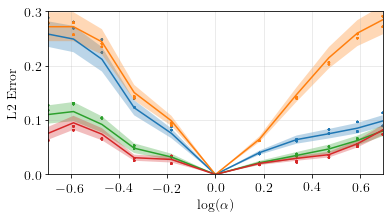

In [24]:
## plots and saves the computed similarity matrix
output_dir = './out/plots/zoom'
savefile_loss = file_name+'_loss_trained_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
# xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
xaxis = np.mean([alphas[:], alphas[:]], axis=0)
# mu = np.mean(dist_trained_info, axis=0)
# sd = np.std(dist_trained_info, axis=0)
# p = ax.plot(xaxis, mu)
# ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
# xscatter = np.tile(xaxis, (20, 1))
# yscatter = dist_trained_info[:20] # take the first 20 samples
# ax.scatter(xscatter, yscatter, marker='.',
#            edgecolors='none', s=20, color=p[0].get_color())


### For noaug + walk
mu_j = np.mean(dist_trained_NoAug_argminW, axis=0)
sd_j = np.std(dist_trained_NoAug_argminW, axis=0)
p_j = ax.plot(xaxis, mu_j)
ax.fill_between(xaxis, mu_j-sd_j, mu_j+sd_j, alpha=0.3)
xscatter_j = np.tile(xaxis, (20,1))
yscatter_j = dist_trained_NoAug_argminW[:20]
ax.scatter(xscatter_j, yscatter_j, marker='.', edgecolors='none', s=20, color=p_j[0].get_color())

### For noaug + joint
mu_j = np.mean(dist_trained_NoAug_argminGW, axis=0)
sd_j = np.std(dist_trained_NoAug_argminGW, axis=0)
p_j = ax.plot(xaxis, mu_j)
ax.fill_between(xaxis, mu_j-sd_j, mu_j+sd_j, alpha=0.3)
xscatter_j = np.tile(xaxis, (20,1))
yscatter_j = dist_trained_NoAug_argminGW[:20]
ax.scatter(xscatter_j, yscatter_j, marker='.', edgecolors='none', s=20, color=p_j[0].get_color())

### For shift aug+walk (this file)
mu = np.mean(dist_trained_info, axis=0)
sd = np.std(dist_trained_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_trained_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
### For shift join
mu_j = np.mean(dist_trained_joint, axis=0)
sd_j = np.std(dist_trained_joint, axis=0)
p_j = ax.plot(xaxis, mu_j)
ax.fill_between(xaxis, mu_j-sd_j, mu_j+sd_j, alpha=0.3)
xscatter_j = np.tile(xaxis, (20,1))
yscatter_j = dist_trained_joint[:20]
ax.scatter(xscatter_j, yscatter_j, marker='.', edgecolors='none', s=20, color=p_j[0].get_color())

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.3])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile_loss + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile_loss + '.pdf'),
          bbox_inches="tight", pad_inches=0)

In [25]:
np.save(os.path.join(output_dir, savefile_transform_effect+'.npy'), dist_info)
np.save(os.path.join(output_dir, savefile_loss+'.npy'), dist_trained_info)